In [1]:
import sys
import itertools
import pandas as pd
import numpy as np
import pathlib

from tqdm.auto import tqdm

In [2]:
sys.path.append("../src")

from utils import number_split, create_mix

# Load Datasets

## Option 1: Load from preprocessed Toy dataset

In [3]:
df_imdb = pd.read_csv("../dataToy/horror_family.csv")

In [4]:
df_imdb['label_binary'] = df_imdb['label'].map({"pos":1,"neg":0})

# Split original dataset into two
df_imdb_horror = df_imdb.query("domain == 'Horror'").reset_index(drop=True)


df_imdb_family = df_imdb.query("domain == 'Family'").reset_index(drop=True)


In [5]:
df_imdb.head()

,id,text,label,score,url,tconst,id_w_tag,set,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,domain,label_binary
0,8286,Larry Fessenden has been thrashed by most of t...,pos,7,http://www.imdb.com/title/tt0275067/usercomments,tt0275067,pos_8286,train,movie,Wendigo,Wendigo,0,2001,\N,91,"Horror,Mystery,Thriller",Horror,1
1,8279,This film is more about how children make sens...,pos,10,http://www.imdb.com/title/tt0275067/usercomments,tt0275067,pos_8279,train,movie,Wendigo,Wendigo,0,2001,\N,91,"Horror,Mystery,Thriller",Horror,1
2,8273,If you want Scream or anything like the big-st...,pos,10,http://www.imdb.com/title/tt0275067/usercomments,tt0275067,pos_8273,train,movie,Wendigo,Wendigo,0,2001,\N,91,"Horror,Mystery,Thriller",Horror,1
3,8276,"Now this is what I'm talking about. Finally, a...",pos,10,http://www.imdb.com/title/tt0275067/usercomments,tt0275067,pos_8276,train,movie,Wendigo,Wendigo,0,2001,\N,91,"Horror,Mystery,Thriller",Horror,1
4,8281,"From the first scene, I was really excited. ""I...",pos,7,http://www.imdb.com/title/tt0275067/usercomments,tt0275067,pos_8281,train,movie,Wendigo,Wendigo,0,2001,\N,91,"Horror,Mystery,Thriller",Horror,1


In [6]:
print(df_imdb_horror.groupby("label").size())
print(df_imdb_family.groupby("label").size())

label
neg    3055
pos    1167
dtype: int64
label
neg    612
pos    782
dtype: int64


In [7]:
print(df_imdb_horror.groupby("label_binary").size())
print(df_imdb_family.groupby("label_binary").size())

label_binary
0    3055
1    1167
dtype: int64
label_binary
0    612
1    782
dtype: int64


## Option 2: Download IMDB Dataset

The link to the original dataset used in this notebook: https://ai.stanford.edu/~amaas/data/sentiment/


For this demo, only data in `train` are used.


- Two provenances: genre-Horror, genre-Family
- Outcome: Positive, Negative

In [ ]:
%%bash
cd ../dataToy

wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz >/dev/null 2>&1

tar -xf aclImdb_v1.tar.gz 

In [ ]:
%%bash
cd ../dataToy

wget https://datasets.imdbws.com/title.basics.tsv.gz >/dev/null 2>&1

gzip -d title.basics.tsv.gz

In [ ]:
df_ls = []



basepath="../dataToy/aclImdb/"
set_name = "train"

tags = ["pos","neg"]


for tag in tags:
    id_ls = []
    score_ls = []
    text_ls = []
    label_ls = []

    url_ls = []
    tconst_ls = []
    
    path = pathlib.Path(basepath, set_name, tag)
    url_file = pathlib.Path(basepath, set_name, f"urls_{tag}.txt")
    
    with open(url_file, "r") as f:
        _allurls = f.readlines()
        url_ls.append([x.rstrip() for x in _allurls])
        tconst_ls.append([x.rstrip().split("/")[-2] for x in _allurls])
    
    for ifile in path.glob("*"):
        with open(ifile, "r") as f:
            txt = f.readlines()

            text_ls.append(" ".join(txt))





        _id, _score = ifile.with_suffix('').name.split("_")

        id_ls.append(int(_id))
        score_ls.append(_score)
        label_ls.append(tag)

    df_tmp = pd.DataFrame({"id":id_ls,
                         "text":text_ls,
                         "label":label_ls,
                         "score":score_ls,
                        })
    
    df_tmp = df_tmp.set_index('id')

    df_url = pd.DataFrame({"url":url_ls[0], "tconst":tconst_ls[0]})

    df_url.index.name = 'id'

    df_tmp = df_tmp.merge(df_url, on='id')



    assert df_tmp.index.nunique() == len(df_tmp)

    df_tmp['id_w_tag'] = df_tmp.index

    df_tmp['id_w_tag'] = df_tmp['id_w_tag'].apply(lambda x: tag + "_" + str(x))
    df_tmp = df_tmp.reset_index()
    
    df_tmp['set'] = set_name
    
    
    df_ls.append(df_tmp)
    
df = pd.concat(df_ls, ignore_index=True)

# get Genre
df_title_basics = pd.read_csv("../dataToy/title.basics.tsv", sep="\t")
df = df.merge(df_title_basics, on="tconst", how='inner')


# select Horror and Family
df_horror = df[df['genres'].str.contains("Horror")].reset_index(drop=True)
df_horror['domain'] = 'Horror'

df_family = df[df['genres'].str.contains("Family")].reset_index(drop=True)
df_family['domain'] = 'Family'


# Merge and Save
df_mix = pd.concat([df_horror, df_family]).reset_index(drop=True)

df_mix.to_csv("../dataToy/horror_family.csv", index=False)

In [ ]:
df_mix.head()

# Split

## Configs

In [8]:
s = []
s.append([[x, 1/x] for x in np.arange(1,10,0.1)])
s = np.array(s).flatten()
s = np.sort(s)

In [9]:
#configure the provenance-specific parameters for train/test splits
n_test = 500 #test set size
train_test_ratio = 4 #train/test ratio (4:1)

p_pos_train_z0_ls = [0.25,0.4,0.5,0.6,0.75] # probability of training set examples drawn from site/domain z0 being positive
p_pos_train_z1_ls = [0.75,0.6,0.5,0.4,0.25] # probability of test set examples drawn from site/domain z1 being positive
# it would also be possible to expand p_pos_train parameters as a list to explore their influence

# fraction of both train/test data drawn from domain z1 irrespective of class label
# fraction drawn from z0 would be 1-p_mix_z1_ls
# this is a list of distributions, experiments will be conducted at each of these settings 
p_mix_z1_ls     = [0.5] # = np.arange(0.1, 0.9, 0.05) 

# alpha_test is p(y=1|z=1) / p(y=1|z=0): the ratio between test set probabilities of the positive class by site/domain
#alpha_test_ls     = [0.125,0.25,0.5,1,2,4,8]

alpha_test_ls = np.arange(0,10,0.1)

#get a balanced range of alpha test
numvals = 103
base = 1.1
alpha_test_ls = np.power(base, np.arange(numvals))/np.power(base,numvals//2)
#could we reduce the base for more granularity

#alternative with narrower intervals
numvals = 1000
s = []
s.append([[x, 1/x] for x in np.arange(1,numvals//2,0.1)])
s = np.array(s).flatten()
#alpha_test_ls = np.sort(list(set(s)))

#check for balance 
print("balanced?",np.sum(alpha_test_ls > 1) - np.sum(alpha_test_ls < 1)==0)
#check for underflow/flow
print("underflow?",np.inf in alpha_test_ls)
#sns.distplot(np.log(alpha_test_ls) / np.log(base))
#print(alpha_test_ls)

balanced? True
underflow? False


In [26]:
import warnings
warnings.filterwarnings('ignore')

<AxesSubplot:ylabel='Density'>

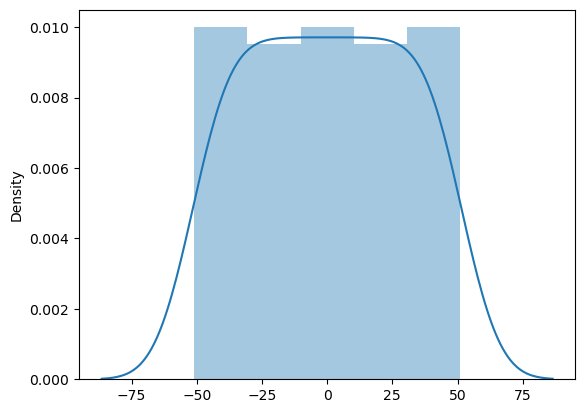

In [27]:
import seaborn as sns
sns.distplot(np.log(alpha_test_ls) / np.log(base))

In [28]:
numvals = 29
alpha_range = np.exp2(np.arange(numvals))/np.power(2,numvals//2)
np.sum(alpha_range > 1) - np.sum(alpha_range < 1)


0

In [29]:
# theoretical numbers
# create combinations of settings meeting the constraints defined in the previous cell




theoretical_full_settings = []
for combination in itertools.product(p_pos_train_z0_ls, 
                                     p_pos_train_z1_ls, 
                                     p_mix_z1_ls,
                                     alpha_test_ls
                                    ):


    number_setting = number_split(p_pos_train_z0=combination[0], 
                           p_pos_train_z1 = combination[1], 
                           p_mix_z1 = combination[2], alpha_test = combination[3],
                           train_test_ratio = train_test_ratio, 
                           n_test=n_test,
                                  verbose=False #set verbose to True to see which invalid combinations are ignored and why
                                 )

    # enforce each group*label has at least 10 samples
    if (number_setting is not None):
        if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
            theoretical_full_settings.append(number_setting)
    

## Inspects

In [30]:
len(theoretical_full_settings)

1233

In [31]:
# check number for one setting
# here we can see how the parameters manifest as numbers of examples to be drawn in each set and probabilities
# to guide this sampling procedure
theoretical_full_settings[0]['mix_param_dict']

{'p_pos_train_z0': 0.25,
 'p_pos_train_z1': 0.75,
 'p_pos_train': 0.5,
 'p_pos_test': 0.5,
 'p_mix_z0': 0.5,
 'p_mix_z1': 0.5,
 'alpha_train': 3.0,
 'alpha_test': 0.043056764313424443,
 'p_pos_test_z0': 0.9587205933688893,
 'p_pos_test_z1': 0.041279406631110696,
 'C_y': 0.5,
 'C_z': 0.5}

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

This plot shows the probabilities of drawing a positive example by site/domain across all configurations generated within the constraints of the parameters defined previously.


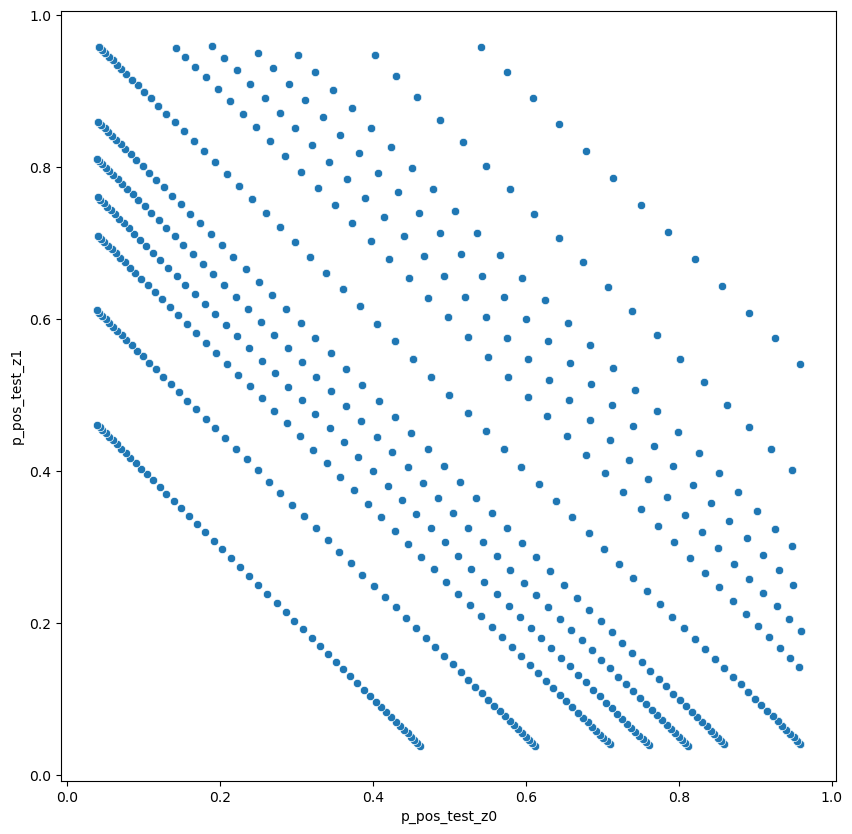

In [33]:
# check distributions of p_pos_test_z0 by p_pos_test_z1
tmp_df = pd.DataFrame([st['mix_param_dict'] for st in theoretical_full_settings])

plt.figure(figsize=(10,10))
sns.scatterplot(x="p_pos_test_z0", y="p_pos_test_z1", data=tmp_df)
print("This plot shows the probabilities of drawing a positive example by site/domain across all configurations generated within the constraints of the parameters defined previously.")

In [34]:
tmp_df.head()

,p_pos_train_z0,p_pos_train_z1,p_pos_train,p_pos_test,p_mix_z0,p_mix_z1,alpha_train,alpha_test,p_pos_test_z0,p_pos_test_z1,C_y,C_z
0,0.25,0.75,0.5,0.5,0.5,0.5,3.0,0.043057,0.958721,0.041279,0.5,0.5
1,0.25,0.75,0.5,0.5,0.5,0.5,3.0,0.047362,0.954779,0.045221,0.5,0.5
2,0.25,0.75,0.5,0.5,0.5,0.5,3.0,0.052099,0.950481,0.049519,0.5,0.5
3,0.25,0.75,0.5,0.5,0.5,0.5,3.0,0.057309,0.945798,0.054202,0.5,0.5
4,0.25,0.75,0.5,0.5,0.5,0.5,3.0,0.063039,0.940699,0.059301,0.5,0.5


In [35]:
import seaborn as sns

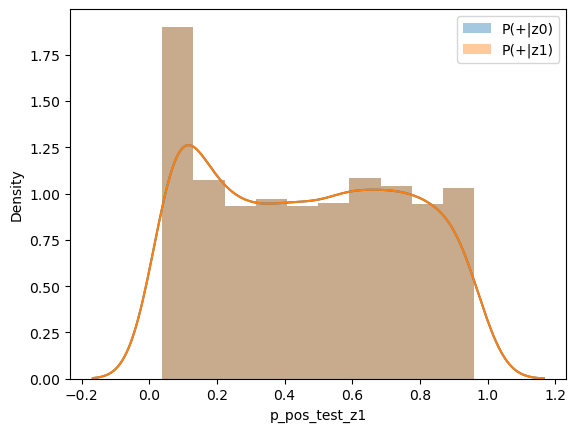

In [36]:
sns.distplot(tmp_df['p_pos_test_z0'],label='P(+|z0)')
sns.distplot(tmp_df['p_pos_test_z1'],label='P(+|z1)')
plt.legend()

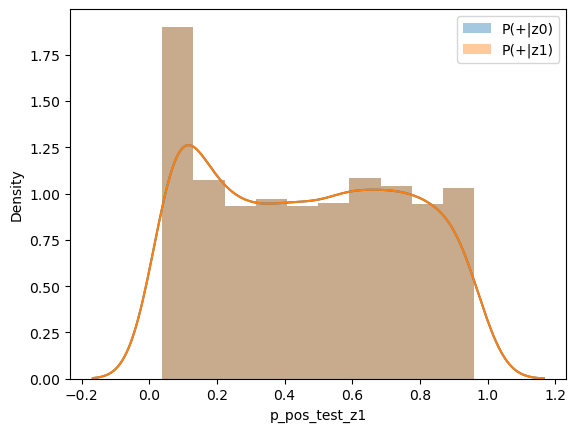

In [37]:
sns.distplot(tmp_df['p_pos_test_z0'],label='P(+|z0)')
sns.distplot(tmp_df['p_pos_test_z1'],label='P(+|z1)')
plt.legend()

## Split Real Datasets

In [38]:
# To ignore warnings when One Theoretical setting could not apply to the real dataset
import warnings
warnings.filterwarnings('ignore')

In [39]:
df_imdb_horror.head(3)

,id,text,label,score,url,tconst,id_w_tag,set,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,domain,label_binary
0,8286,Larry Fessenden has been thrashed by most of t...,pos,7,http://www.imdb.com/title/tt0275067/usercomments,tt0275067,pos_8286,train,movie,Wendigo,Wendigo,0,2001,\N,91,"Horror,Mystery,Thriller",Horror,1
1,8279,This film is more about how children make sens...,pos,10,http://www.imdb.com/title/tt0275067/usercomments,tt0275067,pos_8279,train,movie,Wendigo,Wendigo,0,2001,\N,91,"Horror,Mystery,Thriller",Horror,1
2,8273,If you want Scream or anything like the big-st...,pos,10,http://www.imdb.com/title/tt0275067/usercomments,tt0275067,pos_8273,train,movie,Wendigo,Wendigo,0,2001,\N,91,"Horror,Mystery,Thriller",Horror,1


In [40]:
df_imdb_family.head(3)

,id,text,label,score,url,tconst,id_w_tag,set,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,domain,label_binary
0,11568,One of the many Merrie Melodies cartoons that ...,pos,7,http://www.imdb.com/title/tt0036050/usercomments,tt0036050,pos_11568,train,short,An Itch in Time,An Itch in Time,0,1943,\N,8,"Animation,Comedy,Family",Family,1
1,11570,Elmer Fudd is laughing while lounging in his e...,pos,9,http://www.imdb.com/title/tt0036050/usercomments,tt0036050,pos_11570,train,short,An Itch in Time,An Itch in Time,0,1943,\N,8,"Animation,Comedy,Family",Family,1
2,11571,`An Itch In Time' is one of a string of home r...,pos,9,http://www.imdb.com/title/tt0036050/usercomments,tt0036050,pos_11571,train,short,An Itch in Time,An Itch in Time,0,1943,\N,8,"Animation,Comedy,Family",Family,1


In [41]:

print("Proportion positive sentiment for family",np.mean(df_imdb_family['label']== 'pos'))
print("Proportion positive sentiment for horror", np.mean(df_imdb_horror['label']== 'pos'))

Proportion positive sentiment for family 0.5609756097560976
Proportion positive sentiment for horror 0.2764092846991947


In [42]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

label='label_binary'
df0 = df_imdb_horror
df1 = df_imdb_family


_rand = 252775

acc = []
f1s = []
aps = []
roc = []
alpha_train = []
alpha_test = []

valid_n_full_settings = []
tmp = None
# iterate over theoretical settings
for c in tqdm(theoretical_full_settings):
    c = c.copy()
    dfs = create_mix(df0=df0, df1=df1, target=label, setting=c, sample=True, #False, 
                     # If True will sample with replacement when dataset lacks enough examples to meet constraints
                     # Sampling one only occur in instances where the actual examples are insufficient
                     seed=_rand,
                    )

    # one theoretical setting doesn't apply to real dataset (alternatively we could sample with replacement in these instances)
    if dfs is None:
        continue 
    
    

    #########
    ## Computation here
    #########
    
    # do something with dfs
    tmp = dfs
    count_vect = CountVectorizer()
    train_counts = count_vect.fit_transform(tmp['train']['text'].values)
    tfidf_transformer = TfidfTransformer(use_idf=True).fit(train_counts)
    train_tfidf = tfidf_transformer.transform(train_counts)

    test_counts = count_vect.transform(tmp['test']['text'].values)
    test_tfidf  = tfidf_transformer.transform(test_counts)

    clf  = MultinomialNB().fit(train_tfidf, tmp['train']['label'])
    pred = clf.predict(test_tfidf) 
    prob = clf.predict_proba(test_tfidf)
    pos_prob = [x[1] for x in prob]
    acc.append(np.mean(pred == tmp['test']['label']))
    f1s.append(metrics.f1_score(pred, tmp['test']['label'], pos_label='pos'))
    roc.append(metrics.roc_auc_score(tmp['test']['label'] == 'pos', pos_prob))
    aps.append(metrics.average_precision_score(tmp['test']['label'] == 'pos', pos_prob)) 
    
    valid_n_full_settings.append(c)
    alpha_test.append(c['mix_param_dict']['alpha_test'])
    alpha_train.append(c['mix_param_dict']['alpha_train'])

  0%|          | 0/1233 [00:00<?, ?it/s]

In [43]:
import pandas as pd
rframe = pd.DataFrame(valid_n_full_settings)
rframe['f1s'] = np.asarray(f1s)
rframe['roc'] = np.asarray(roc)
rframe['aps'] = np.asarray(aps)
rframe['acc'] = np.asarray(acc)
rframe['alpha_train'] = np.asarray(alpha_train)
rframe['alpha_test'] = np.asarray(alpha_test)

In [44]:
for key in rframe['mix_param_dict'][0].keys():
    rframe[key] = [np.round(x[key],2) for x in rframe['mix_param_dict']]

In [45]:
set(rframe['p_pos_train_z0'])

{0.25, 0.4, 0.5, 0.6, 0.75}

In [46]:
set(rframe['alpha_train'])

{0.33,
 0.42,
 0.5,
 0.53,
 0.62,
 0.67,
 0.8,
 0.83,
 1.0,
 1.2,
 1.25,
 1.5,
 1.6,
 1.88,
 2.0,
 2.4,
 3.0}

In [47]:
rframe['mix_param_dict'][0]

{'p_pos_train_z0': 0.25,
 'p_pos_train_z1': 0.75,
 'p_pos_train': 0.5,
 'p_pos_test': 0.5,
 'p_mix_z0': 0.5,
 'p_mix_z1': 0.5,
 'alpha_train': 3.0,
 'alpha_test': 0.043056764313424443,
 'p_pos_test_z0': 0.9587205933688893,
 'p_pos_test_z1': 0.041279406631110696,
 'C_y': 0.5,
 'C_z': 0.5}

In [48]:
for key in rframe['mix_param_dict'][0].keys():
    print(key,np.std(rframe[key]))

p_pos_train_z0 0.1625511534636759
p_pos_train_z1 0.1625511534636759
p_pos_train 0.10143610380940071
p_pos_test 0.10143610380940071
p_mix_z0 0.0
p_mix_z1 0.0
alpha_train 0.693451221789222
alpha_test 4.52425298937081
p_pos_test_z0 0.2839545257330345
p_pos_test_z1 0.2839545257330345
C_y 0.10143610380940071
C_z 0.0


<AxesSubplot:xlabel='C_y', ylabel='Density'>

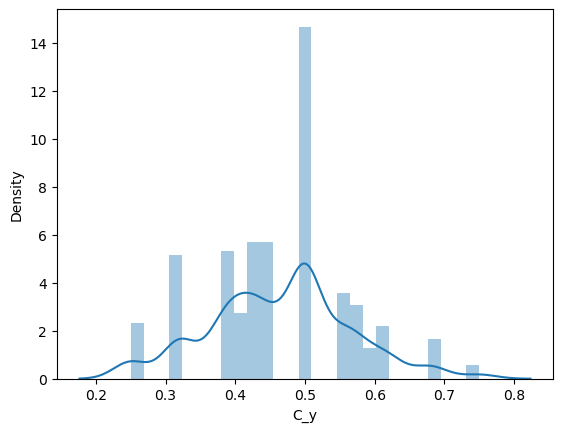

In [49]:
sns.distplot(rframe['C_y'])

In [50]:
#C_y : overall positive rate in train and test
#C_z : currently always 0.5

In [51]:
set(rframe['alpha_train'])

{0.33,
 0.42,
 0.5,
 0.53,
 0.62,
 0.67,
 0.8,
 0.83,
 1.0,
 1.2,
 1.25,
 1.5,
 1.6,
 1.88,
 2.0,
 2.4,
 3.0}

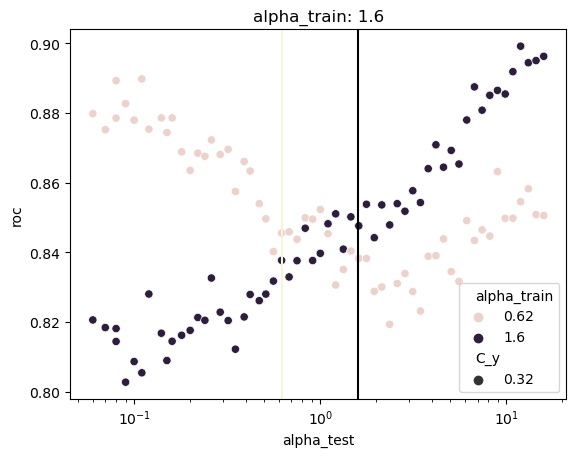

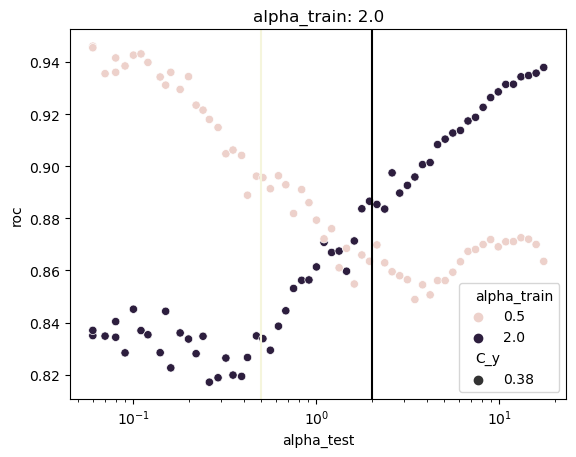

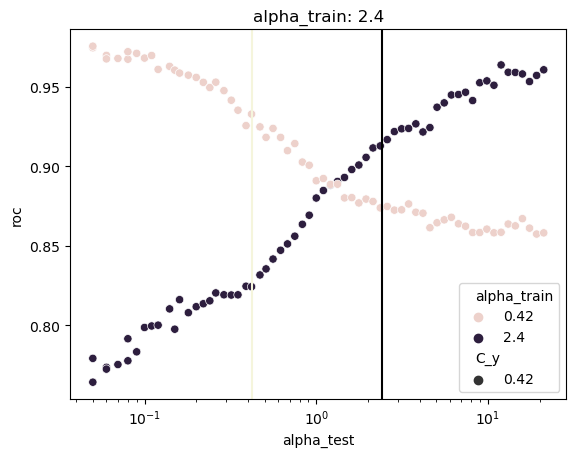

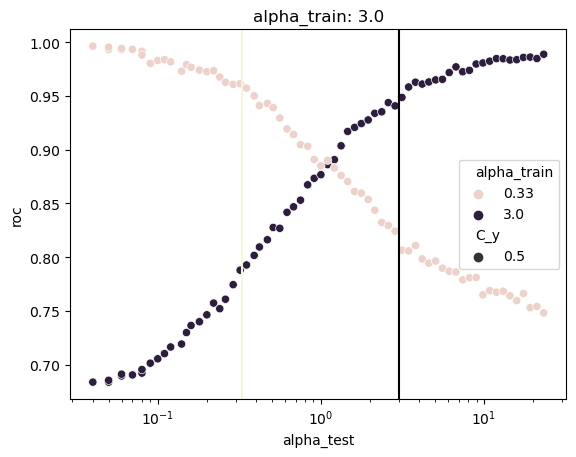

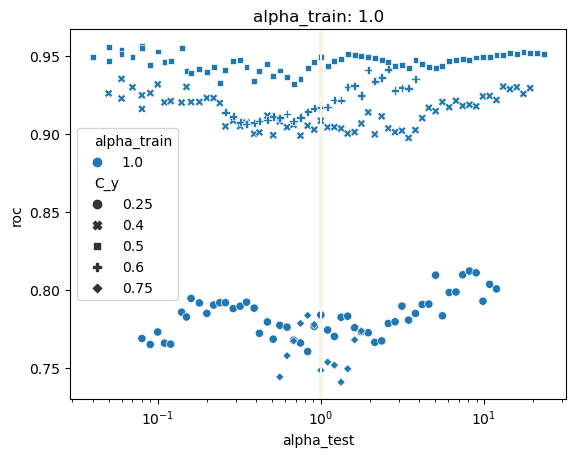

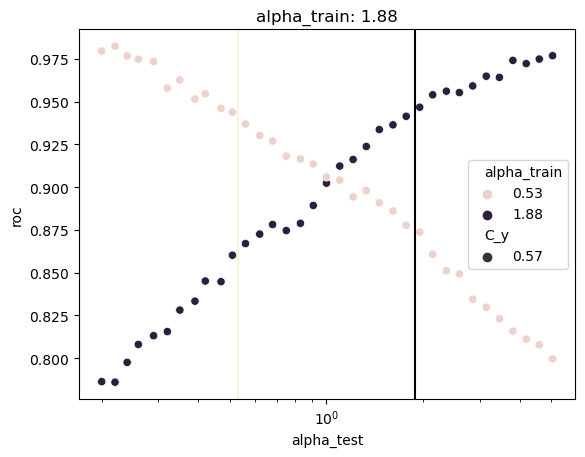

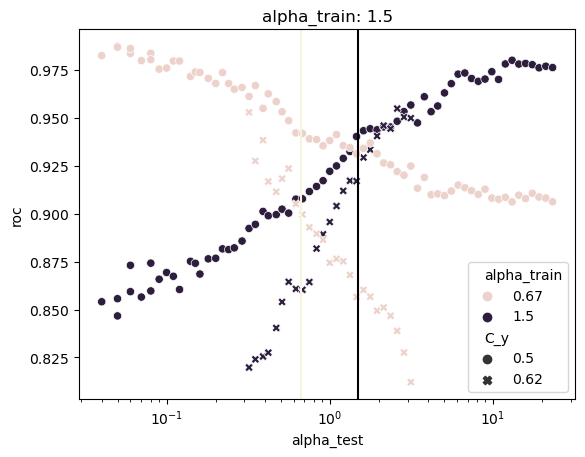

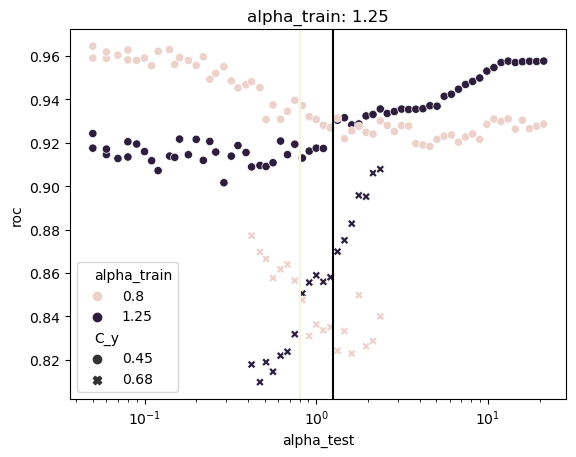

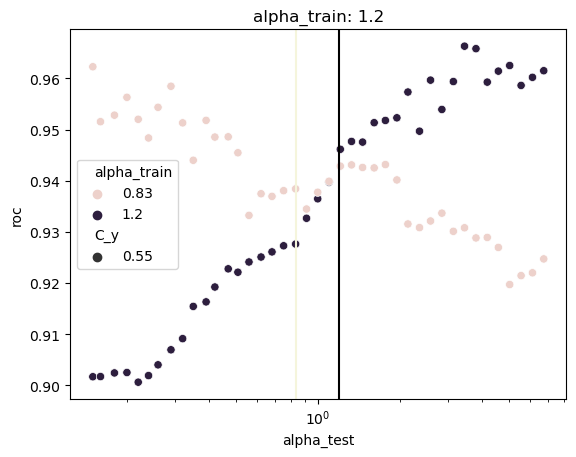

In [344]:
import seaborn as sns
for alpha_train in set(rframe['alpha_train']):
    if alpha_train >=1:
        #alpha_train = 1.6  # if 1, then p(pos_train | z1) == p(pos_train | z0)
        reciprocal = round(1 / alpha_train, 2)
        sns.scatterplot(data=rframe[(rframe['alpha_train'] == alpha_train) | (rframe['alpha_train'] == reciprocal) ],x='alpha_test',y='roc', hue='alpha_train', style='C_y')#, x_estimator=np.mean)
        #sns.lineplot(data=rframe[rframe['alpha_train'] == alpha_train], x='alpha_test', y='aps', hue='C_y')
        plt.xscale('log')
        plt.axvline(alpha_train,color='black')
        plt.axvline(reciprocal, color='beige')
        plt.title('alpha_train: ' + str(alpha_train))
        plt.show()

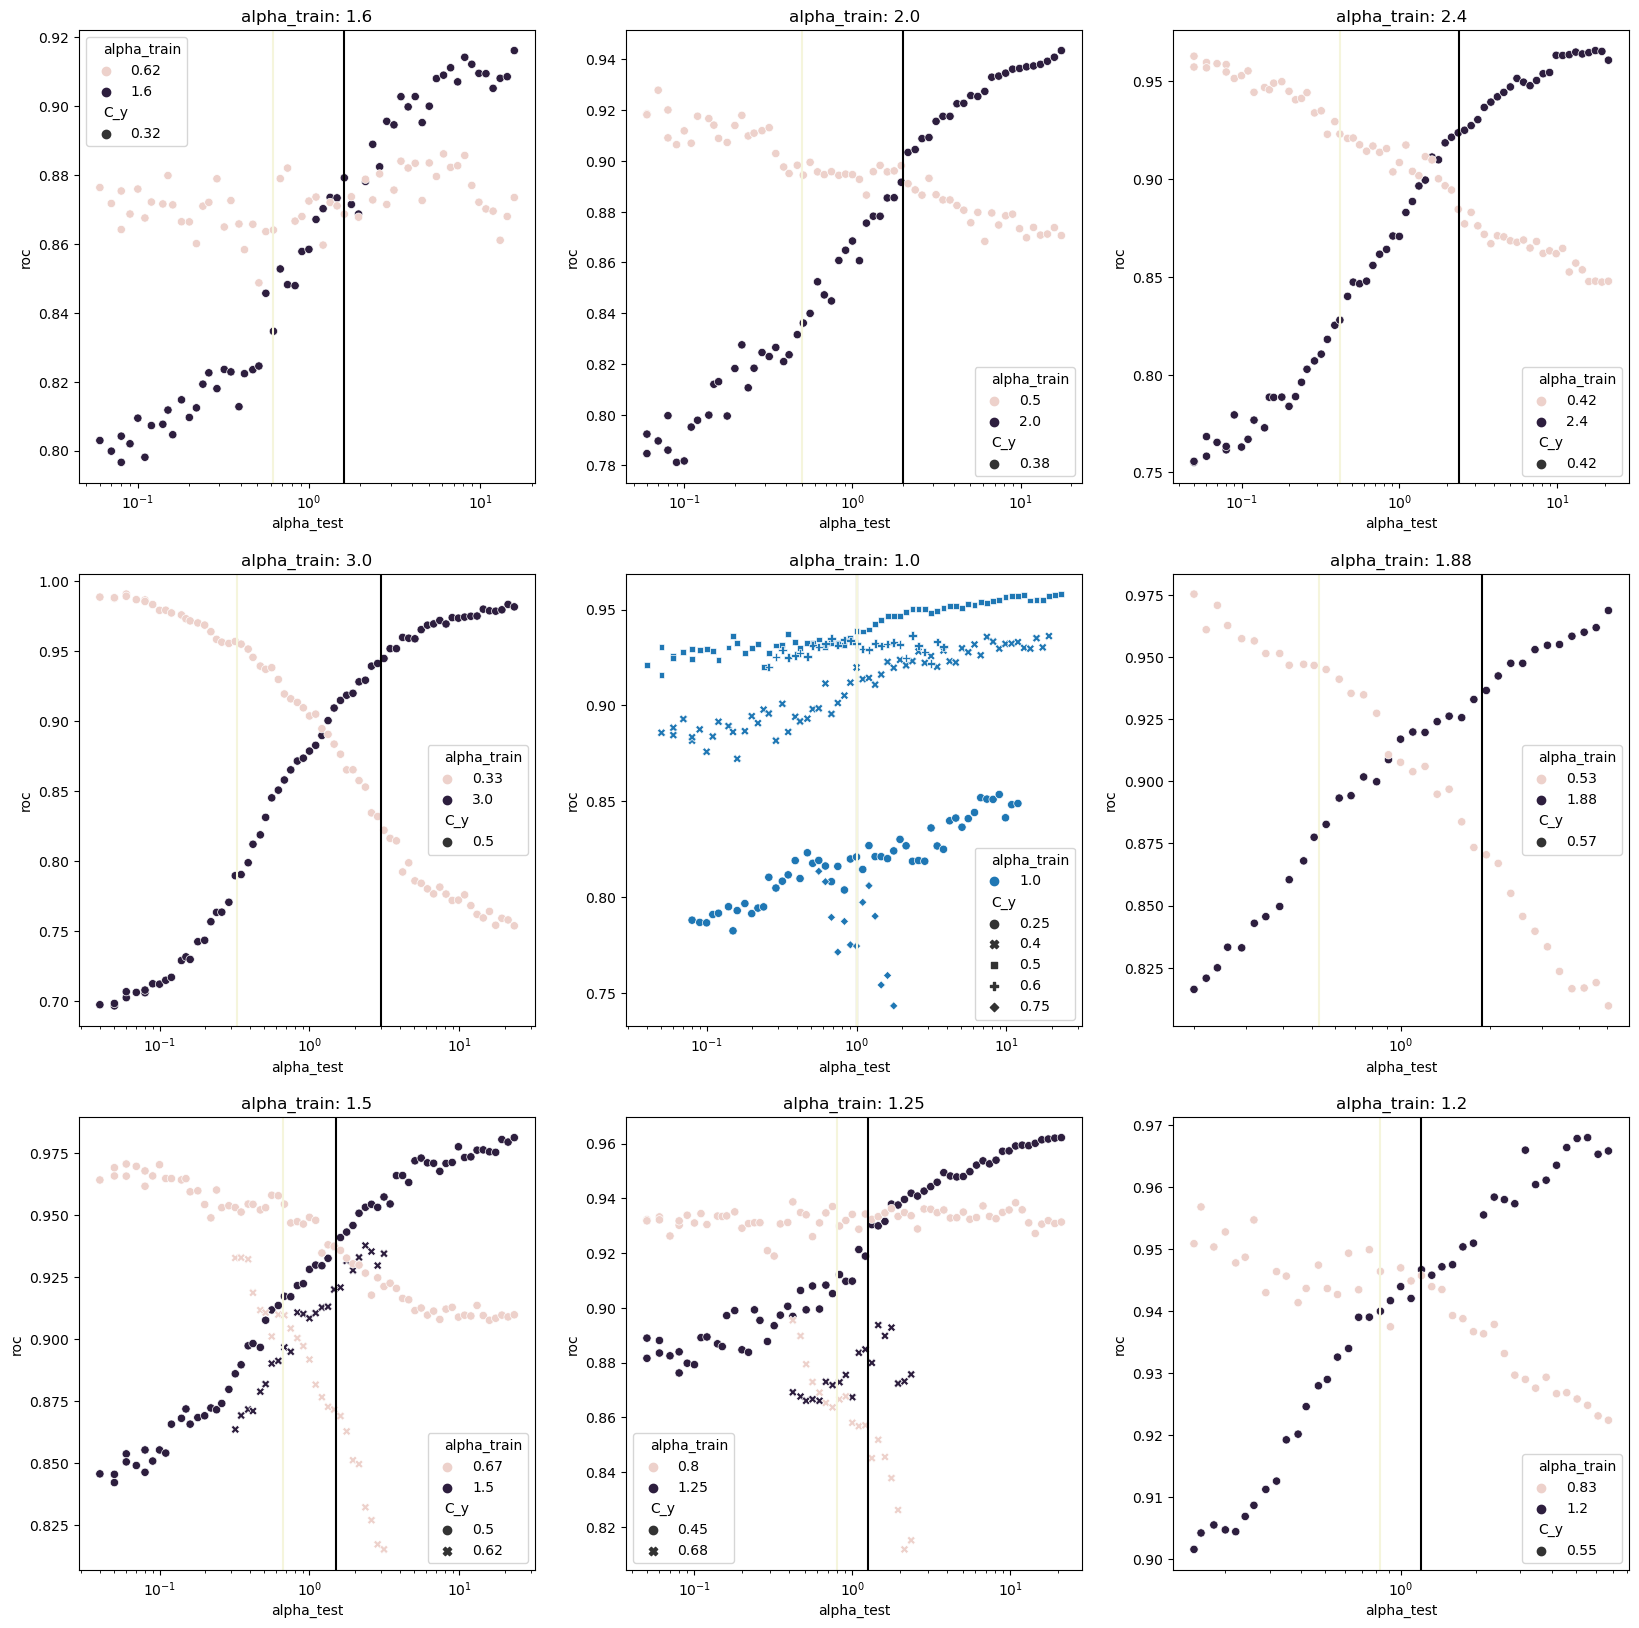

In [67]:
import seaborn as sns

fig, axs = plt.subplots(3, 3, figsize=(20,20))

alpha_train_plt_ls = [x for x in set(rframe['alpha_train']) if x >= 1]

for a_train, ax in zip(alpha_train_plt_ls, axs.ravel()):
    
    

    reciprocal = round(1 / a_train, 2)
    sns.scatterplot(data=rframe[(rframe['alpha_train'] == a_train) | (rframe['alpha_train'] == reciprocal) ],
                    x='alpha_test', y='roc', 
                    hue='alpha_train', style='C_y',
                    ax=ax
                   )
    #sns.lineplot(data=rframe[rframe['alpha_train'] == alpha_train], x='alpha_test', y='aps', hue='C_y')
    ax.set_xscale('log')
    ax.axvline(a_train,color='black')
    ax.axvline(reciprocal, color='beige')
    ax.set_title('alpha_train: ' + str(a_train))
    # plt.show()

## no sampling
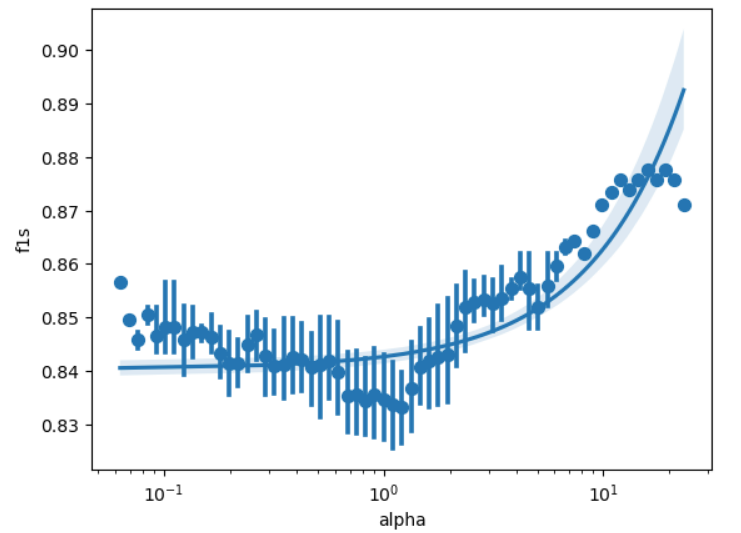

In [79]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

count_vect = CountVectorizer()
train_counts = count_vect.fit_transform(tmp['train']['text'].values)
tfidf_transformer = TfidfTransformer(use_idf=True).fit(train_counts)
train_tfidf = tfidf_transformer.transform(train_counts)

test_counts = count_vect.transform(tmp['test']['text'].values)
test_tfidf  = tfidf_transformer.transform(test_counts)

clf  = MultinomialNB().fit(train_tfidf, tmp['train']['label'])
pred = clf.predict(test_tfidf) 
prob = clf.predict_proba(test_tfidf)
pos_prob = [x[1] for x in prob]
np.mean(pred == tmp['test']['label'])
metrics.f1_score(pred, tmp['test']['label'], pos_label='pos')
metrics.roc_auc_score(tmp['test']['label'] == 'pos', pos_prob)
metrics.average_precision_score(tmp['test']['label'] == 'pos', pos_prob)

0.952919935531447

In [28]:
len(valid_n_full_settings)

287

This plot shows the probabilities of drawing a positive example by site/domain across all configurations generated within the constraints of the parameters defined previously.


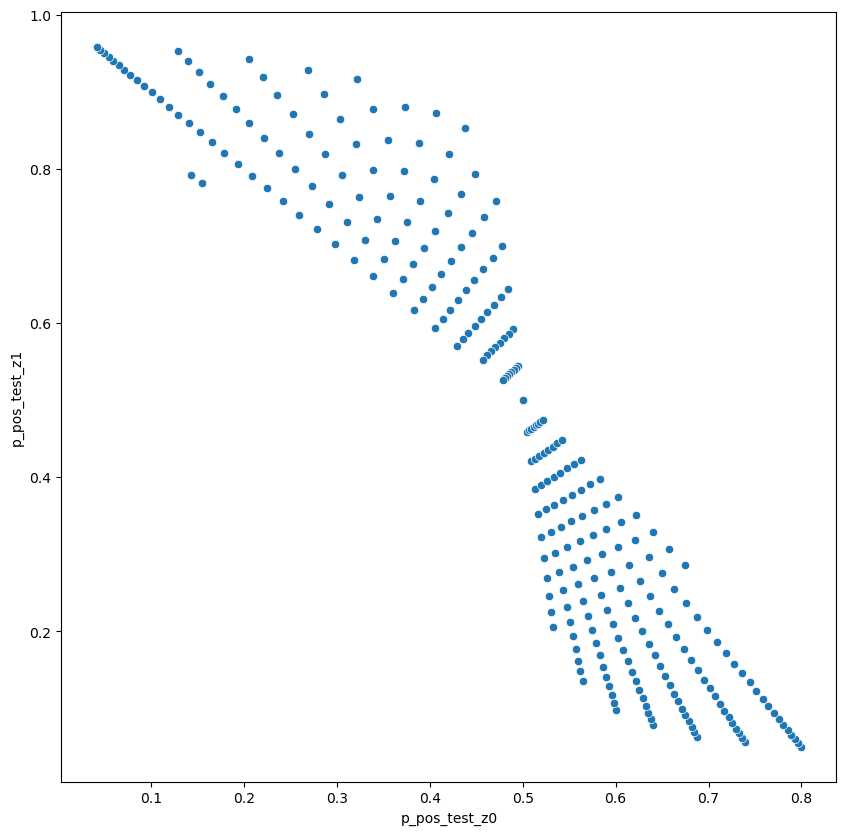

In [29]:
# check distributions of p_pos_test_z0 by p_pos_test_z1
tmp_df = pd.DataFrame([st['mix_param_dict'] for st in valid_n_full_settings])

plt.figure(figsize=(10,10))
sns.scatterplot(x="p_pos_test_z0", y="p_pos_test_z1", data=tmp_df)
print("This plot shows the probabilities of drawing a positive example by site/domain across all configurations generated within the constraints of the parameters defined previously.")

<Axes: xlabel='alpha_test', ylabel='Density'>

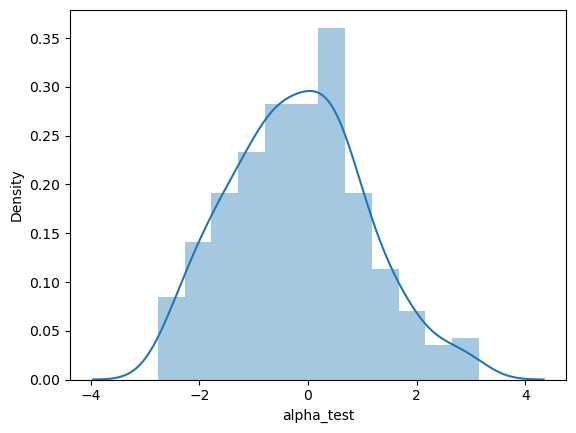

In [30]:
sns.distplot(np.log(tmp_df['alpha_test']))

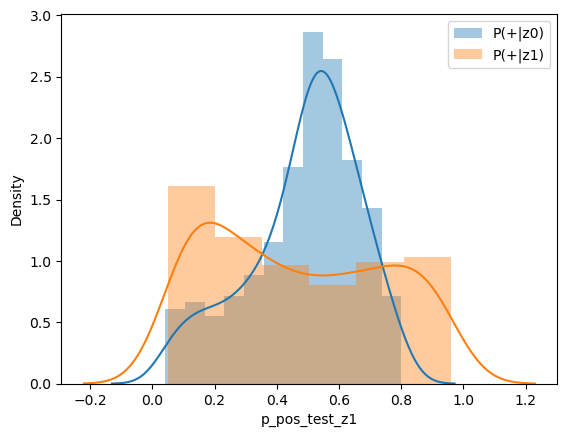

In [31]:
sns.distplot(tmp_df['p_pos_test_z0'],label='P(+|z0)')
sns.distplot(tmp_df['p_pos_test_z1'],label='P(+|z1)')
plt.legend()

In [32]:
tmp_df.head()

,p_pos_train_z0,p_pos_train_z1,p_pos_train,p_pos_test,p_mix_z0,p_mix_z1,alpha_train,alpha_test,p_pos_test_z0,p_pos_test_z1,C_y,C_z
0,0.5,0.5,0.5,0.5,0.9,0.1,1.0,0.385543,0.532734,0.205392,0.5,0.1
1,0.5,0.5,0.5,0.5,0.9,0.1,1.0,0.424098,0.530555,0.225007,0.5,0.1
2,0.5,0.5,0.5,0.5,0.9,0.1,1.0,0.466507,0.528178,0.246399,0.5,0.1
3,0.5,0.5,0.5,0.5,0.9,0.1,1.0,0.513158,0.525588,0.269710,0.5,0.1
4,0.5,0.5,0.5,0.5,0.9,0.1,1.0,0.564474,0.522768,0.295089,0.5,0.1


In [33]:
tmp_df.head()

,p_pos_train_z0,p_pos_train_z1,p_pos_train,p_pos_test,p_mix_z0,p_mix_z1,alpha_train,alpha_test,p_pos_test_z0,p_pos_test_z1,C_y,C_z
0,0.5,0.5,0.5,0.5,0.9,0.1,1.0,0.385543,0.532734,0.205392,0.5,0.1
1,0.5,0.5,0.5,0.5,0.9,0.1,1.0,0.424098,0.530555,0.225007,0.5,0.1
2,0.5,0.5,0.5,0.5,0.9,0.1,1.0,0.466507,0.528178,0.246399,0.5,0.1
3,0.5,0.5,0.5,0.5,0.9,0.1,1.0,0.513158,0.525588,0.269710,0.5,0.1
4,0.5,0.5,0.5,0.5,0.9,0.1,1.0,0.564474,0.522768,0.295089,0.5,0.1


<Axes: xlabel='p_mix_z0', ylabel='Density'>

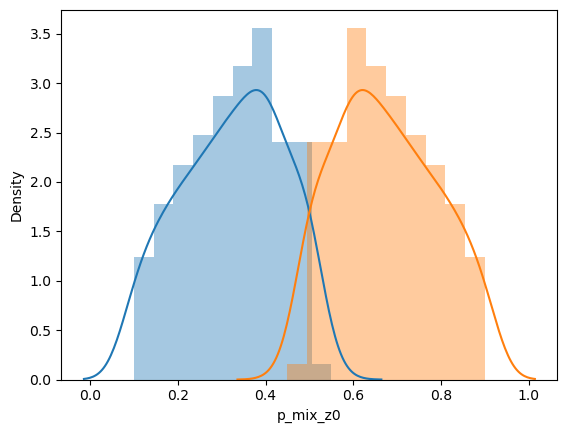

In [34]:
sns.distplot(tmp_df['p_mix_z1'])
sns.distplot(tmp_df['p_mix_z0'])

## Check Structure of One Resulting `dfs`

In [35]:
tmp.keys()

dict_keys(['train', 'test', 'setting'])

['train'] and ['test'] are of the exact same format as input datasets:

In [ ]:
tmp['setting']

In [ ]:
tmp['train'].head()

In [ ]:
tmp['test'].head()

## Classify

In [40]:
#metadata
print(len(tmp_df))
tmp_df.head()

287


,p_pos_train_z0,p_pos_train_z1,p_pos_train,p_pos_test,p_mix_z0,p_mix_z1,alpha_train,alpha_test,p_pos_test_z0,p_pos_test_z1,C_y,C_z
0,0.5,0.5,0.5,0.5,0.9,0.1,1.0,0.385543,0.532734,0.205392,0.5,0.1
1,0.5,0.5,0.5,0.5,0.9,0.1,1.0,0.424098,0.530555,0.225007,0.5,0.1
2,0.5,0.5,0.5,0.5,0.9,0.1,1.0,0.466507,0.528178,0.246399,0.5,0.1
3,0.5,0.5,0.5,0.5,0.9,0.1,1.0,0.513158,0.525588,0.269710,0.5,0.1
4,0.5,0.5,0.5,0.5,0.9,0.1,1.0,0.564474,0.522768,0.295089,0.5,0.1


In [41]:
valid_n_full_settings[0]

{'n_train': 2000,
 'n_test': 500,
 'n_z0_pos_train': 900,
 'n_z0_neg_train': 900,
 'n_z0_pos_test': 240,
 'n_z0_neg_test': 210,
 'n_z1_pos_train': 100,
 'n_z1_neg_train': 100,
 'n_z1_pos_test': 10,
 'n_z1_neg_test': 40,
 'mix_param_dict': {'p_pos_train_z0': 0.5,
  'p_pos_train_z1': 0.5,
  'p_pos_train': 0.5,
  'p_pos_test': 0.5,
  'p_mix_z0': 0.9,
  'p_mix_z1': 0.1,
  'alpha_train': 1.0,
  'alpha_test': 0.3855432894295314,
  'p_pos_test_z0': 0.5327342110958297,
  'p_pos_test_z1': 0.2053921001375326,
  'C_y': 0.5,
  'C_z': 0.1}}